In [1]:
pip install tf-keras


Note: you may need to restart the kernel to use updated packages.


Imports and Configuration

In [2]:

import os, json, time
import numpy as np
import pandas as pd
import requests
import streamlit as st
from collections import Counter, defaultdict


os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


st.set_page_config(page_title="Wesnoth PR Clustering", layout="wide")
st.title("Patch Patterns: Clustering Similar Pull Requests")


C:\Users\kaosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-10-26 21:20:18.826 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.826 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.937 
  command:

    streamlit run C:\Users\kaosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-26 21:20:18.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

Streamlit Configuration

In [3]:
st.set_page_config(page_title="Wesnoth PR Clustering", layout="wide")
st.title("Patch Patterns: Clustering Similar Pull Requests")

2025-10-26 21:20:18.951 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:18.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

Read GitHub token from Streamlit Secrets

In [4]:
# --- Secrets ---
GITHUB_TOKEN = st.secrets.get("GITHUB_TOKEN", "")
if not GITHUB_TOKEN:
    st.info("ℹ️ Add a GitHub token in Streamlit → Settings → Secrets as `GITHUB_TOKEN`.")


GitHub API helpers (cached)

In [5]:
# --- GitHub API helpers (cached) ---
@st.cache_data(show_spinner=False)
def gh_get(url: str, token: str, params: dict | None = None, accept: str | None = None):
    headers = {"Authorization": f"Bearer {token}"} if token else {}
    if accept: headers["Accept"] = accept
    r = requests.get(url, headers=headers, params=params, timeout=60)
    if r.status_code == 403 and "rate limit" in r.text.lower():
        reset = int(r.headers.get("X-RateLimit-Reset", time.time()+60))
        sleep_s = max(1, reset - int(time.time()) + 1)
        time.sleep(sleep_s)
        r = requests.get(url, headers=headers, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

@st.cache_data(show_spinner=True)
def fetch_merged_prs(owner: str, repo: str, target: int, token: str):
    GITHUB_API = "https://api.github.com"
    prs, page, per_page = [], 1, 100
    while len(prs) < target:
        url = f"{GITHUB_API}/repos/{owner}/{repo}/pulls"
        params = {"state": "closed", "per_page": per_page, "page": page, "sort": "updated", "direction": "desc"}
        batch = gh_get(url, token, params=params)
        if not batch: break
        merged = [pr for pr in batch if pr.get("merged_at")]
        prs.extend(merged)
        page += 1
        if len(batch) < per_page: break
    return prs[:target]

@st.cache_data(show_spinner=True)
def fetch_pr_details(owner: str, repo: str, numbers: list[int], token: str):
    GITHUB_API = "https://api.github.com"
    out = []
    for n in numbers:
        files = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}/files", token)
        commits = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}/commits", token)
        pr = gh_get(f"{GITHUB_API}/repos/{owner}/{repo}/pulls/{n}", token)
        file_entries = [{
            "filename": f.get("filename"),
            "status": f.get("status"),
            "additions": f.get("additions"),
            "deletions": f.get("deletions"),
            "changes":  f.get("changes"),
            "patch":    f.get("patch"),
        } for f in files]
        commit_msgs = [c.get("commit", {}).get("message","") for c in commits]
        labels = [lab.get("name") for lab in pr.get("labels", [])]
        out.append({
            "number": pr.get("number"),
            "title": pr.get("title"),
            "user": pr.get("user", {}).get("login"),
            "state": pr.get("state"),
            "merged_at": pr.get("merged_at"),
            "created_at": pr.get("created_at"),
            "updated_at": pr.get("updated_at"),
            "labels": labels,
            "body": pr.get("body"),
            "files": file_entries,
            "commits_messages": commit_msgs,
            "html_url": pr.get("html_url"),
        })
    return out


2025-10-26 21:20:19.388 No runtime found, using MemoryCacheStorageManager
2025-10-26 21:20:19.392 No runtime found, using MemoryCacheStorageManager
2025-10-26 21:20:19.393 No runtime found, using MemoryCacheStorageManager


Text building for embeddings

In [6]:
# --- Text block builder ---
def build_text_block(rec: dict) -> str:
    title = rec.get("title") or ""
    body = rec.get("body") or ""
    commits = "\n".join(rec.get("commits_messages") or [])
    files = rec.get("files") or []
    changed_paths = " ".join([f.get("filename","") for f in files])
    return f"TITLE: {title}\nBODY: {body}\nCOMMITS:\n{commits}\nFILES: {changed_paths}".strip()


Embedding model loading and encoding (cached)

In [7]:
# --- Embedding (cached) ---
@st.cache_resource(show_spinner=True)
def load_embed_model(model_name: str):
    return SentenceTransformer(model_name)

@st.cache_data(show_spinner=True)
def embed_records(data: list[dict], model_name: str):
    texts = [build_text_block(r) for r in data]
    model = load_embed_model(model_name)
    emb = model.encode(texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    index_rows = [{
        "number": r.get("number"),
        "title": r.get("title"),
        "labels": ",".join(r.get("labels") or []),
        "url": r.get("html_url"),
    } for r in data]
    return emb, pd.DataFrame(index_rows), texts


2025-10-26 21:20:19.411 No runtime found, using MemoryCacheStorageManager


Clustering via threshold graph → connected components

In [8]:
# --- Clustering ---
def cluster_by_threshold(emb: np.ndarray, threshold: float):
    sim = cosine_similarity(emb)
    np.fill_diagonal(sim, 1.0)
    n = sim.shape[0]

    # Union-Find for connected components (faster than building NetworkX graph on large n)
    parent = list(range(n))
    rank = [0]*n
    def find(x):
        if parent[x]!=x: parent[x]=find(parent[x])
        return parent[x]
    def union(x,y):
        rx,ry = find(x),find(y)
        if rx==ry: return
        if rank[rx]<rank[ry]: parent[rx]=ry
        elif rank[rx]>rank[ry]: parent[ry]=rx
        else: parent[ry]=rx; rank[rx]+=1

    for i in range(n):
        row = sim[i, i+1:]
        js = np.where(row >= threshold)[0] + (i+1)
        for j in js: union(i,j)

    root_to_id, cid = {}, 0
    cluster_ids = np.zeros(n, dtype=int) - 1
    for i in range(n):
        r = find(i)
        if r not in root_to_id:
            root_to_id[r] = cid
            cid += 1
        cluster_ids[i] = root_to_id[r]
    return cluster_ids


Small utilities for preview and analysis

In [9]:
# --- Utilities: preview + analysis ---
def top_title_tokens(df_with_titles: pd.DataFrame, max_tokens=8):
    import re
    rows = []
    grp = df_with_titles.groupby("cluster_id")
    for cid, g in grp:
        toks = []
        for t in g["title"].fillna(""):
            toks += [w for w in re.findall(r"[A-Za-z][A-Za-z0-9_+-]{2,}", t.lower())
                     if w not in {"the","and","for","with","into","from","this","that","fix","pr"}]
        common = " ".join([w for w,_ in Counter(toks).most_common(max_tokens)])
        rows.append({"cluster_id": cid, "n_items": len(g), "top_title_tokens": common})
    return pd.DataFrame(rows).sort_values("n_items", ascending=False)

def explode_labels(s: str) -> list[str]:
    if not isinstance(s, str) or not s.strip(): return []
    return [x.strip() for x in s.split(",") if x.strip()]

def path_counts_by_cluster(df_clusters: pd.DataFrame, num_to_record: dict[int, dict]):
    counts = defaultdict(Counter)
    for r in df_clusters.itertuples():
        rec = num_to_record.get(int(r.number))
        if not rec: continue
        for f in (rec.get("files") or []):
            fn = (f.get("filename") or "").strip()
            if fn:
                top = fn.split("/")[0] if "/" in fn else fn
                counts[r.cluster_id][top] += 1
    rows = []
    for cid, cnt in counts.items():
        for p, n in cnt.most_common(8):
            rows.append({"cluster_id": cid, "path": p, "count": n})
    return pd.DataFrame(rows)


Sidebar controls (owner/repo/target/model/threshold + buttons)

In [10]:
# --- Sidebar controls ---
st.sidebar.header("Settings")
owner = st.sidebar.text_input("GitHub Owner", value="wesnoth")
repo = st.sidebar.text_input("GitHub Repo", value="wesnoth")
target = st.sidebar.slider("Merged PRs to fetch", min_value=100, max_value=600, value=400, step=50)
model_name = st.sidebar.text_input("Embedding model", value="sentence-transformers/all-MiniLM-L6-v2")
threshold = st.sidebar.slider("Clustering threshold", min_value=0.70, max_value=0.98, value=0.92, step=0.01)

fetch_btn = st.sidebar.button("1) Fetch PRs")
embed_btn = st.sidebar.button("2) Embed")
cluster_btn = st.sidebar.button("3) Cluster & Analyze")


2025-10-26 21:20:19.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.445 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.445 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.447 Session state does not function when running a script without `streamlit run`
2025-10-26 21:20

Session state

In [11]:
# --- Session state store ---
if "raw_rows" not in st.session_state: st.session_state.raw_rows = None
if "index_df" not in st.session_state: st.session_state.index_df = None
if "emb" not in st.session_state: st.session_state.emb = None
if "cluster_df" not in st.session_state: st.session_state.cluster_df = None
if "text_blocks" not in st.session_state: st.session_state.text_blocks = None


2025-10-26 21:20:19.475 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.476 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.476 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Button actions (fetch → embed → cluster & analyze)

In [12]:
# --- Actions ---
if fetch_btn:
    if not GITHUB_TOKEN:
        st.error("Please add `GITHUB_TOKEN` in your Streamlit app secrets.")
    else:
        st.info("Fetching merged PRs…")
        merged = fetch_merged_prs(owner, repo, target, GITHUB_TOKEN)
        numbers = [m["number"] for m in merged]
        rows = fetch_pr_details(owner, repo, numbers, GITHUB_TOKEN)
        st.session_state.raw_rows = rows
        st.success(f"Fetched {len(rows)} PRs.")
        st.dataframe(pd.DataFrame([{
            "number": r["number"], "title": r["title"], "labels": ", ".join(r.get("labels") or []), "url": r["html_url"]
        } for r in rows]).head(20))

if embed_btn:
    if not st.session_state.raw_rows:
        st.warning("Fetch PRs first.")
    else:
        st.info("Embedding PRs…")
        emb, index_df, texts = embed_records(st.session_state.raw_rows, model_name)
        st.session_state.emb = emb
        st.session_state.index_df = index_df
        st.session_state.text_blocks = texts
        st.success(f"Embeddings ready. Shape: {emb.shape}")
        st.dataframe(index_df.head(10))

if cluster_btn:
    if st.session_state.emb is None or st.session_state.index_df is None:
        st.warning("Run embedding first.")
    else:
        st.info("Clustering by threshold…")
        cids = cluster_by_threshold(st.session_state.emb, threshold)
        out = st.session_state.index_df.copy()
        out["cluster_id"] = cids
        st.session_state.cluster_df = out
        st.success("Clustering complete.")

        # Largest clusters
        st.subheader("Largest clusters")
        sizes = out.groupby("cluster_id")["number"].count().sort_values(ascending=False)
        st.write(sizes.head(20))

        # Preview keywords
        st.subheader("Cluster preview (top title tokens)")
        st.dataframe(top_title_tokens(out))

        # Labels per cluster
        st.subheader("Label heatmap rows (top labels per cluster)")
        label_rows = []
        grp = out.groupby("cluster_id")
        for cid, g in grp:
            cnt = Counter()
            for labs in g["labels"].fillna(""):
                cnt.update(explode_labels(labs))
            for lab, n in cnt.most_common(6):
                label_rows.append({"cluster_id": cid, "label": lab, "count": n})
        label_df = pd.DataFrame(label_rows)
        st.dataframe(label_df.head(40))

        # Path stats per cluster (uses original JSON)
        st.subheader("Path stats (top-level directories per cluster)")
        num_to_record = {r["number"]: r for r in st.session_state.raw_rows}
        path_df = path_counts_by_cluster(out, num_to_record)
        st.dataframe(path_df.head(40))


Similarity search

In [13]:
# --- Similarity search ---
st.header("Similarity Search")
query = st.text_area("Paste a new issue/PR description", height=180,
                     placeholder="e.g., Fix AI pathfinding bug in campaign X …")
topk = st.slider("Top K", 5, 30, 10)

if st.button("Search similar PRs"):
    if st.session_state.emb is None or st.session_state.index_df is None:
        st.warning("Please embed (step 2) first.")
    else:
        model = load_embed_model(model_name)
        qv = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        sims = cosine_similarity(qv, st.session_state.emb)[0]
        order = np.argsort(-sims)[:topk]
        res = st.session_state.index_df.iloc[order].copy()
        res.insert(1, "similarity", sims[order])
        st.dataframe(res)
        for r in res.itertuples():
            st.markdown(f"**PR #{int(r.number)}** — [{r.title}]({r.url})  \nSimilarity: `{r.similarity:.3f}`  \nLabels: `{r.labels}`")


2025-10-26 21:20:19.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 21:20:19.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [14]:
!pip install sentence-transformers pandas numpy scikit-learn matplotlib requests


In [15]:
import requests, json, time, pandas as pd, os
from getpass import getpass

OWNER, REPO, TARGET = "wesnoth", "wesnoth", 400
TOKEN = getpass("GitHub token: ")
API = "https://api.github.com"

def gh(url, params=None):
    h = {"Authorization": f"Bearer {TOKEN}"} if TOKEN else {}
    r = requests.get(url, headers=h, params=params, timeout=60)
    if r.status_code==403 and "rate limit" in r.text.lower():
        reset = int(r.headers.get("X-RateLimit-Reset", time.time()+60))
        time.sleep(max(1, reset-int(time.time())+1))
        r = requests.get(url, headers=h, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def fetch_merged_prs(owner, repo, target):
    out, page = [], 1
    while len(out)<target:
        batch = gh(f"{API}/repos/{owner}/{repo}/pulls",
                   {"state":"closed","per_page":100,"page":page,"sort":"updated","direction":"desc"})
        if not batch: break
        out += [pr for pr in batch if pr.get("merged_at")]
        page += 1
        if len(batch)<100: break
    return out[:target]

def details(owner, repo, num):
    files = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}/files")
    commits = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}/commits")
    pr = gh(f"{API}/repos/{owner}/{repo}/pulls/{num}")
    return {
        "number": pr["number"],
        "title": pr["title"],
        "labels": [x["name"] for x in pr.get("labels",[])],
        "body": pr.get("body"),
        "files": [{"filename": f.get("filename")} for f in files],
        "commits_messages": [c["commit"]["message"] for c in commits],
        "url": pr["html_url"]
    }

merged = fetch_merged_prs(OWNER, REPO, TARGET)
rows = [details(OWNER, REPO, pr["number"]) for pr in merged]
os.makedirs("data", exist_ok=True)
json.dump(rows, open("data/wesnoth_pr_data.json","w"), indent=2)
idx = pd.DataFrame([{"number":r["number"],"title":r["title"],
                     "labels":",".join(r["labels"]), "url":r["url"]} for r in rows])
idx.to_csv("data/wesnoth_index.csv", index=False)
idx.head()


,number,title,labels,url
0,10635,Fix shema cumulative= valide for no numerical ...,"Unit Tests,Units,Schema,Campaign DiD,Campaign ...",https://github.com/wesnoth/wesnoth/pull/10635
1,10633,Sort terrain entries alphabetically.,"Help,Terrain",https://github.com/wesnoth/wesnoth/pull/10633
2,10537,Revert 'Balancing Update' to Dwarvish Miner,Units,https://github.com/wesnoth/wesnoth/pull/10537
3,10621,GUI2/Story Viewer: title text positioning supp...,"UI,Schema",https://github.com/wesnoth/wesnoth/pull/10621
4,10625,Check for secret,"CI,Android",https://github.com/wesnoth/wesnoth/pull/10625


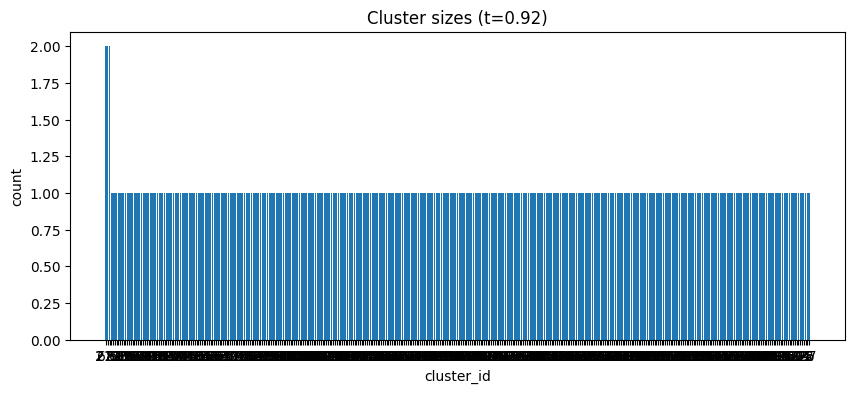

cluster_id
68     2
217    2
222    2
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
365    1
28     1
381    1
1      1
Name: number, dtype: int64

In [24]:
import numpy as np, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd, json
%matplotlib inline
def block(r):
    files = " ".join([f.get("filename","") for f in r.get("files",[])])
    cmts = "\n".join(r.get("commits_messages",[]))
    return f"TITLE: {r.get('title','')}\nBODY: {r.get('body','')}\nCOMMITS:\n{cmts}\nFILES: {files}"

data = json.load(open("data/wesnoth_pr_data.json"))
texts = [block(r) for r in data]
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

# threshold clustering
def cluster(emb, thr=0.92):
    sim = cosine_similarity(emb); np.fill_diagonal(sim,1.0)
    n = sim.shape[0]
    parent = list(range(n)); rank=[0]*n
    def find(x):
        if parent[x]!=x: parent[x]=find(parent[x]); return parent[x]
        return x
    def union(a,b):
        ra,rb = find(a),find(b)
        if ra==rb: return
        if rank[ra]<rank[rb]: parent[ra]=rb
        elif rank[ra]>rank[rb]: parent[rb]=ra
        else: parent[rb]=ra; rank[ra]+=1
    for i in range(n):
        js = np.where(sim[i, i+1:]>=thr)[0]+(i+1)
        for j in js: union(i,j)
    roots = {}
    cid = np.full(n, -1)
    next_id=0
    for i in range(n):
        r = find(i)
        if r not in roots: roots[r]=next_id; next_id+=1
        cid[i]=roots[r]
    return cid

cids = cluster(emb, 0.92)
df = pd.read_csv("data/wesnoth_index.csv")
df["cluster_id"] = cids

# Plot cluster sizes
sizes = df.groupby("cluster_id")["number"].count().sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (t=0.92)"); plt.xlabel("cluster_id"); plt.ylabel("count")
plt.show()

sizes.head(15)


In [17]:
sizes.sort_values(ascending=False).head(10)


cluster_id
217    2
222    2
68     2
7      1
8      1
9      1
10     1
11     1
12     1
365    1
Name: number, dtype: int64

In [18]:
df[df["cluster_id"] == 68][["number", "title", "labels", "url"]]


,number,title,labels,url
68,10545,MP: Fix lag during AI turns on 5P The Wilderlands,"MP,Stable 1.18",https://github.com/wesnoth/wesnoth/pull/10545
69,10482,MP: Fix lag during AI turns on 5P The Wilderlands,MP,https://github.com/wesnoth/wesnoth/pull/10482


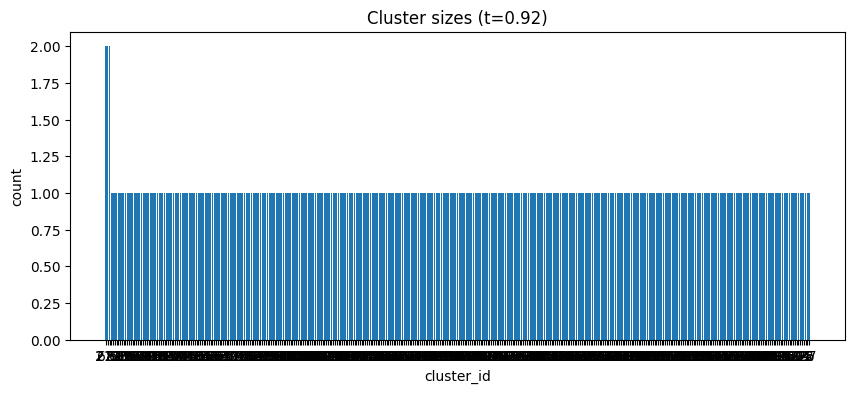

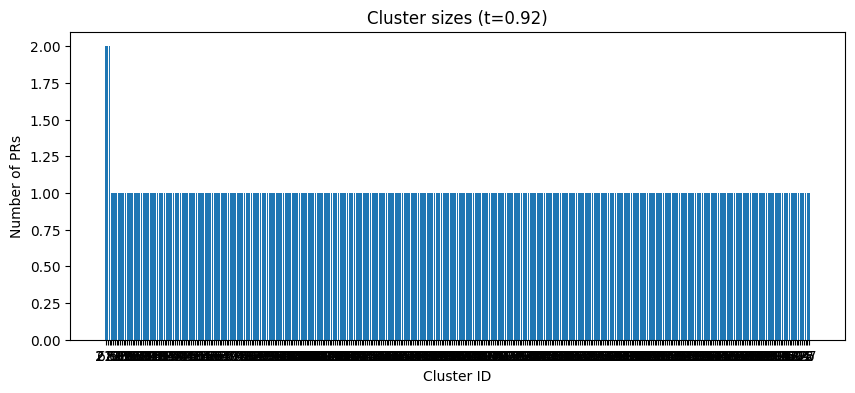

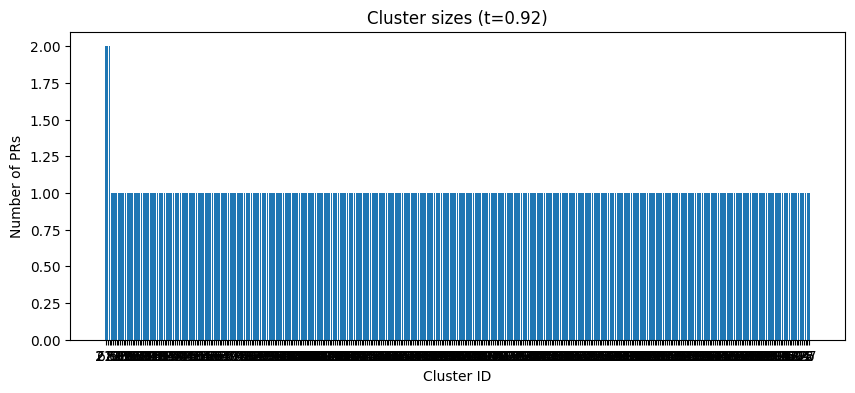

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (t=0.92)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of PRs")
plt.show()


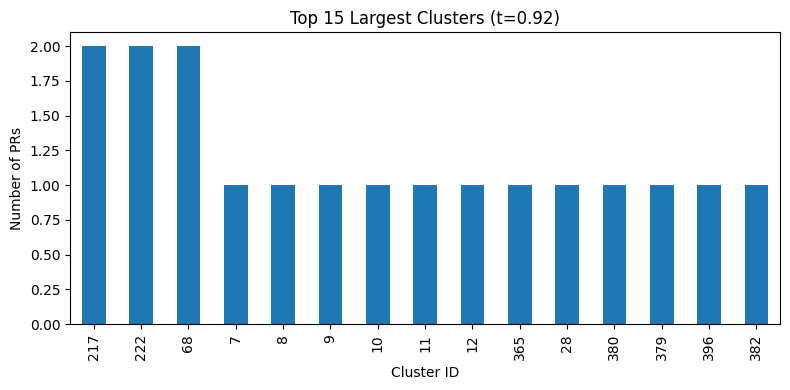

In [21]:
import matplotlib.pyplot as plt

top_n = 15
top_sizes = sizes.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, 4))
top_sizes.plot(kind='bar')
plt.title(f"Top {top_n} Largest Clusters (t=0.92)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of PRs")
plt.tight_layout()
plt.show()


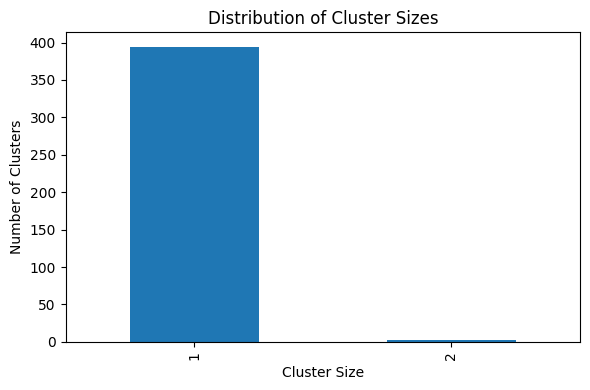

In [22]:
plt.figure(figsize=(6, 4))
sizes.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Cluster Sizes")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.tight_layout()
plt.show()


In [23]:
print("Total clusters:", len(sizes))
print("Single-PR clusters:", (sizes==1).sum())
print("Multi-PR clusters:", (sizes>1).sum())
print("Largest cluster size:", sizes.max())


Total clusters: 397
Single-PR clusters: 394
Multi-PR clusters: 3
Largest cluster size: 2
